In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [2]:
data_dir = '/kaggle/input/hand-gesture-recognition/HandGesture/images'
base_dir = '/kaggle/working/'

os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)

        # Splitting data
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Creating category folders in train, val, and test
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Moving images to respective folders
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category))
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category))
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category))

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Setting parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 64
NUM_CLASSES = 10

# Loading the Xception model, excluding the top layer
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
# Freezing the base model layers to retain pre-trained weights
base_model.trainable = False

# Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Creating the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Preprocessing the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3664 images belonging to 10 classes.
Found 788 images belonging to 10 classes.
Found 791 images belonging to 10 classes.


In [8]:
# Training the model (initial training with frozen base model)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734547026.865624      89 service.cc:145] XLA service 0x7ebf9c002030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734547026.865682      89 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734547026.865686      89 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-18 18:37:12.964770: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[64,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,147,147]{3,2,1,0}, f32[64,1,3,3]{3,2,1

57/57 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6063 - loss: 1.1405 - val_accuracy: 0.9544 - val_loss: 0.1924
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.8906 - loss: 0.2875

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.8906 - loss: 0.2875 - val_accuracy: 0.9500 - val_loss: 0.2320
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9250 - loss: 0.2476 - val_accuracy: 0.9714 - val_loss: 0.1179
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - loss: 0.1081 - val_accuracy: 1.0000 - val_loss: 0.0200
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9441 - loss: 0.1781 - val_accuracy: 0.9661 - val_loss: 0.1118
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0780 - val_accuracy: 0.9500 - val_loss: 0.2460
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9578 - loss: 0.1514 - val_accuracy: 0.9844 - val_loss: 0.0667


In [11]:
# Evaluating on Test Data
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 450ms/step - accuracy: 0.9820 - loss: 0.0832
Test Loss: 0.0983
Test Accuracy: 0.9779


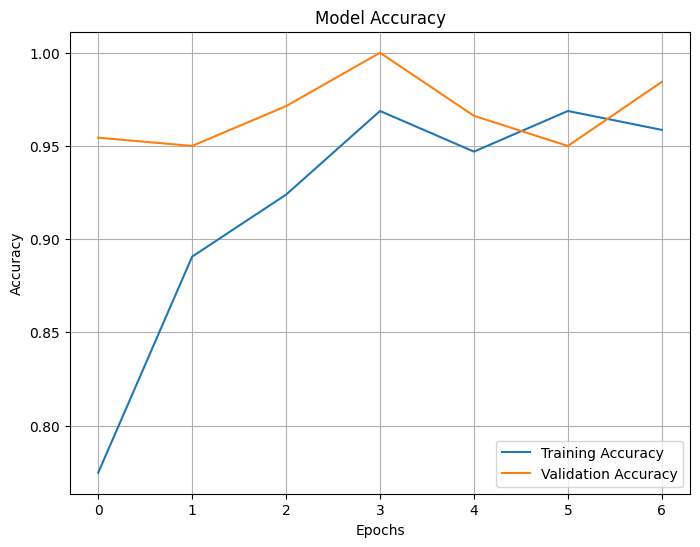

In [13]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

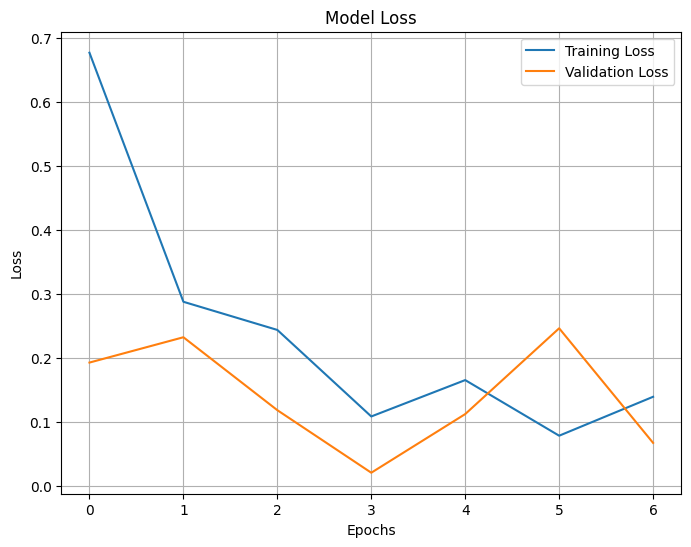

In [14]:
# Plotting Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Getting Predictions and Ground Truth Labels
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=1)
true_classes = test_generator.classes

# Class Labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step
                 precision    recall  f1-score   support

        call_me       0.96      1.00      0.98        80
fingers_crossed       0.97      0.97      0.97        76
           okay       0.98      0.99      0.98        81
          paper       1.00      0.98      0.99        81
          peace       0.99      0.92      0.95        79
           rock       1.00      1.00      1.00        77
        rock_on       0.99      1.00      0.99        80
        scissor       0.94      0.97      0.96        80
         thumbs       0.97      0.96      0.97        81
             up       0.99      0.99      0.99        76

       accuracy                           0.98       791
      macro avg       0.98      0.98      0.98       791
   weighted avg       0.98      0.98      0.98       791



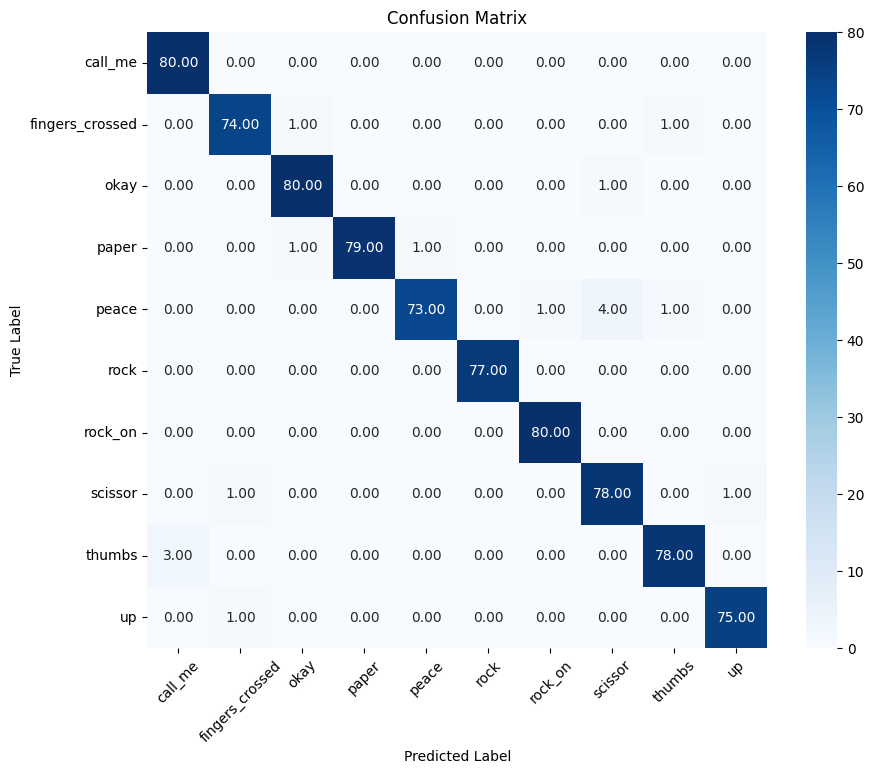

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

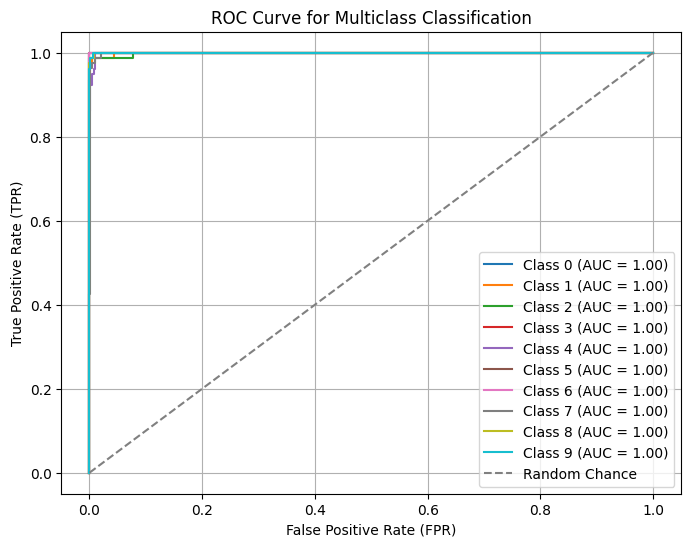

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize true_classes for multiclass
n_classes = len(test_generator.class_indices)
true_classes_binarized = label_binarize(true_classes, classes=list(range(n_classes)))

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.title('ROC Curve for Multiclass Classification')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()